In [1]:
#|default_exp augment

## Augmentation 

In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [2]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
#|export
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

In [5]:
astats = ActivationStatsCB(append_stats, fc.risinstance(GeneralRelu))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [6]:
set_seed(42)
lr,epochs = 6e-2,5

### Going Wider

In [82]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [8]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.786,0.841,0,True
0.866,0.508,0,False
0.896,0.397,1,True
0.885,0.364,1,False
0.917,0.279,2,True
0.910,0.287,2,False
0.937,0.209,3,True
0.926,0.246,3,False
0.958,0.152,4,True
0.933,0.222,4,False


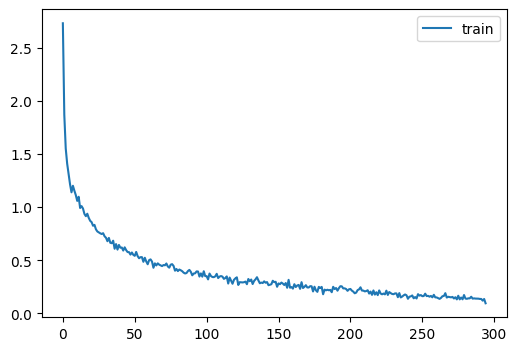

In [10]:
learn.fit(epochs)

### Pooling 

In [9]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

Create model 2 which starts with a 5x5 kernel.
layer 1: 28 16ch
layer 2: 14 32ch
layer 3: 7 64ch
layer 4: 4 128ch
layer 5: 2 156ch
layer 6: 1 512 ch
It then uses global average pooling instead of flatten

In [10]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [11]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [12]:
xb = next(iter(dls.train))[0][:16]

In [ ]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

In [ ]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

The previous model has a lot of flops and parameters in the last conv layer.  Lets remove that and see how the model performs

In [14]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [ ]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

accuracy,loss,epoch,train
0.733,1.005,0,True
0.781,0.791,0,False
0.887,0.430,1,True
0.875,0.415,1,False
0.913,0.294,2,True
0.906,0.294,2,False
0.931,0.228,3,True
0.913,0.277,3,False
0.948,0.180,4,True
0.928,0.234,4,False


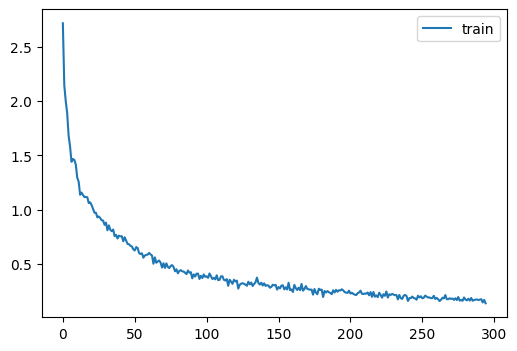

In [22]:
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [23]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1]),
 torch.Size([16])]

Now instead of starting with a ResBlock the first layer will just be a normal conv

In [15]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

It can be seent that there are a lot fewer parameters in the first block

In [25]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16])]

In [26]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224948; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.762,0.907,0,True
0.872,0.462,0,False
0.894,0.409,1,True
0.884,0.377,1,False
0.914,0.287,2,True
0.899,0.321,2,False
0.935,0.218,3,True
0.917,0.268,3,False
0.956,0.162,4,True
0.928,0.235,4,False


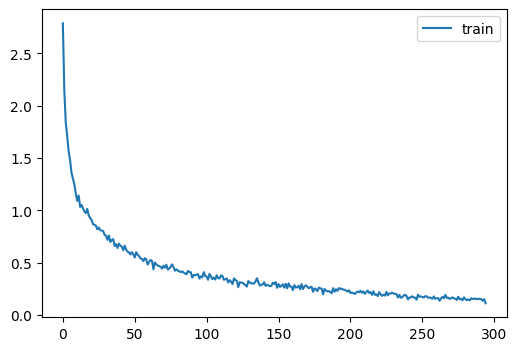

In [27]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

### Data augmentation

After 20 epochs without augmentation:

```
{'accuracy': '0.999', 'loss': '0.012', 'epoch': 19, 'train': True}
{'accuracy': '0.924', 'loss': '0.284', 'epoch': 19, 'train': False}
```

With batchnorm, weight decay doesn't really regularize.

The loss for the training is also looking lower than the loss for the validation, which suggests the model is starting to overfit

In [16]:
from torchvision import transforms

In [17]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

In [19]:
learn.fit(1)

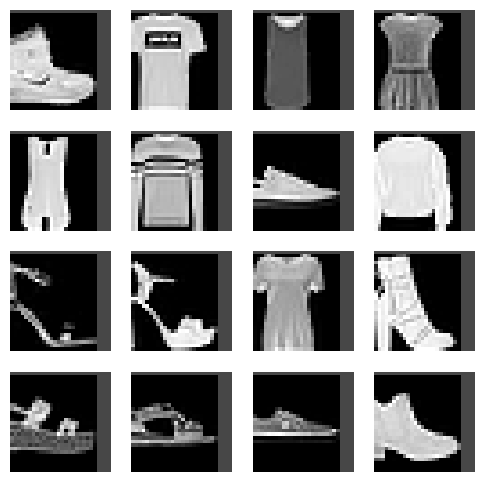

In [20]:
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

Create a function to show a batch of images and assign to a learner using a patch
The delegates decorator is a way to allow us to see the parameters of the function delegated to when defining
the new function (ie when creating show_image_batch, we can see and tab complete any of the show_image parameters)

In [18]:
#| export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

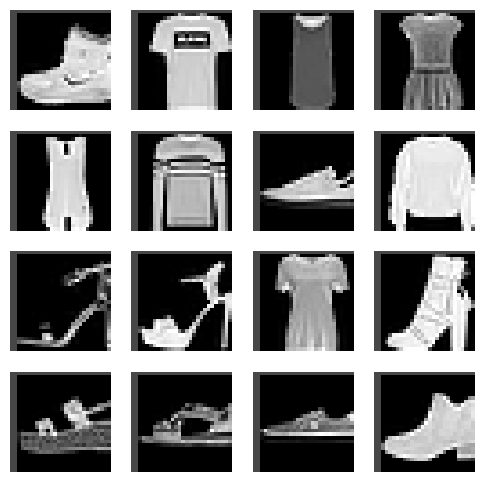

In [14]:
learn.show_image_batch(max_n=16, imsize=(1.5))

In [19]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train
0.722,1.031,0,True
0.793,0.774,0,False
0.850,0.638,1,True
0.845,0.576,1,False
0.875,0.496,2,True
0.860,0.482,2,False
0.881,0.416,3,True
0.885,0.361,3,False
0.893,0.346,4,True
0.874,0.363,4,False


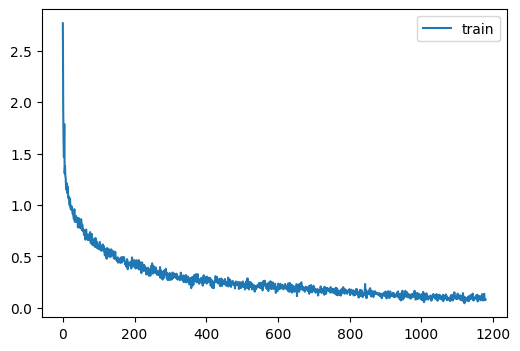

In [24]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

A custom collation function could let you do per-item transformations.

In [20]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [ ]:
torch.save(learn.model, mdl_path/'data_aug.pkl')

In [21]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [17]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
learn.model = torch.load(mdl_path/'data_aug.pkl')

## Test Time Augmentation 

Test time augmentaton runs the same image through the model multiple times after augmentation and then uses an aggregation function to assign a class based upon some analysis of the aggregated results. 

Firstly create a class to capture all of the predictions and targets.  Note that the assumption is made that this is done with the validation set and no shuffling of data occurs

In [22]:
#|export
class CapturePreds(Callback):
    def before_fit(self, learn):
        self.all_inps, self.all_preds, self.all_targs = [], [], []
        
    def after_batch(self, learn):
        self.all_inps.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    
    def after_fit(self, learn):
        self.all_preds, self.all_targs, self.all_inps = map(torch.cat, 
                                                            [self.all_preds,self.all_targs,self.all_inps]) 

In [ ]:
# Now patch the above into the learner class

In [23]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

In [20]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.944,0.174,0,False


In [21]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

accuracy,loss,epoch,train
0.941,0.177,0,False


In [22]:
ap1.shape,ap2.shape,at.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]), torch.Size([10000]))

In [23]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

In [24]:
round((ap==at).float().mean().item(), 3)

0.944

In this case the TTA score is no better than the base case, however, normally this would be run for more cycles, which should improve the results

## Random Erase

Random erase is an augmentation method whereby a random square is removed from an image and replaced by gaussian noise. One issue with this is how to ensure that the gaussian noise has a mean and standard comparable to the rest of the image, as is de,onstrated below

In [24]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [25]:
# Calculate the overall mean and standard deviation for the first 16 images
xm, xs = xbt.mean(), xbt.std()
xm, xs

(tensor(-0.02), tensor(1.03))

It can be seen that after the normalisation transforms the input data is gaussian

In [26]:
xbt.min(), xbt.max()

(tensor(-0.80), tensor(2.06))

Calculate coordinates for a square in the image of a certain percentage of the image size which can then be used for removal

In [27]:
pct = 0.2
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-2])
stx = int(random.random()*(1-pct)*xbt.shape[-2])
sty = int(random.random()*(1-pct)*xbt.shape[-1])          
stx, sty, szx, szy         

(14, 0, 5, 5)

Use these coordinates and replace the images at these coordinates with random noise

In [29]:
init.normal_(xbt[:, :, stx:stx+szx, sty:sty+szy], mean=xm, std=xs);

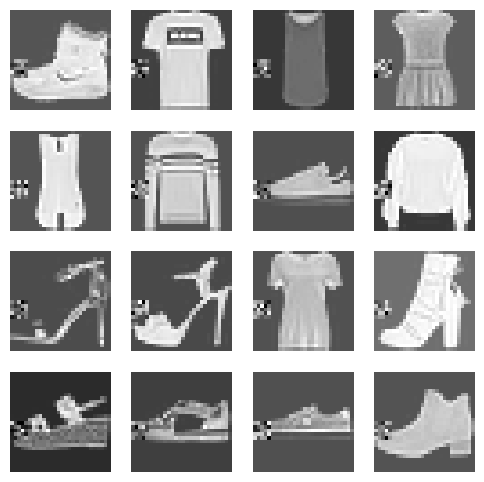

In [30]:
show_images(xbt, imsize=1.5)

In [31]:
xbt.min(), xbt.max()

(tensor(-3.01), tensor(2.87))

It can be seen that the range and std deviation of the images is now much larger.  Visible inspection of the images shows that this is due to the replacement pixels having a range that is independent of the individual images, which are often a subset of the oveall range of the images.  To overcome this we can try to clamp the ranges of the replacement parts of the images

In [28]:
#|export
def _rand_erase1(x, # batch of images
                pct, # percentage of image to be erased
                xm, # mean of images over batch
                xs, # std of images over batch
                mn, # minimum value of clamp
                mx # maximum value of clamp
               ):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-2])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:, :, stx:stx+szx, sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

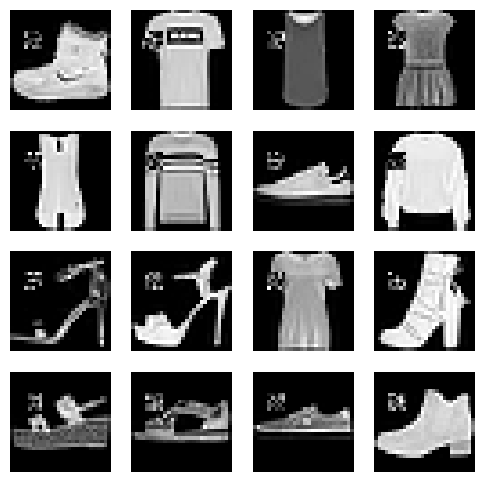

In [29]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

In [30]:
xbt.mean(),xbt.std(),xbt.min(), xbt.max()

(tensor(-0.01), tensor(1.02), tensor(-0.80), tensor(2.06))

In [31]:
#|export
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
    return x

In [32]:
test, _ = next(iter(dls.train))
test2 = copy(test)

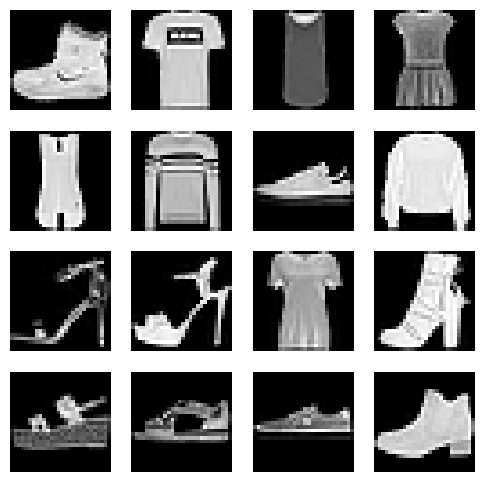

In [33]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

The above brings things the replacement zones into better alignment with the rest of the images.  This will be added as a class that can be included in a transforms pipeline

In [34]:
#|export
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct, self.max_num = pct, max_num

    def forward(self, x):
        #import pdb; pdb.set_trace()
        return rand_erase(x, self.pct, self.max_num)
        

Create a new transform pipeline using nn.Sequential, and add RandErase.  Then assign this pipeline to the batch callback

In [35]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

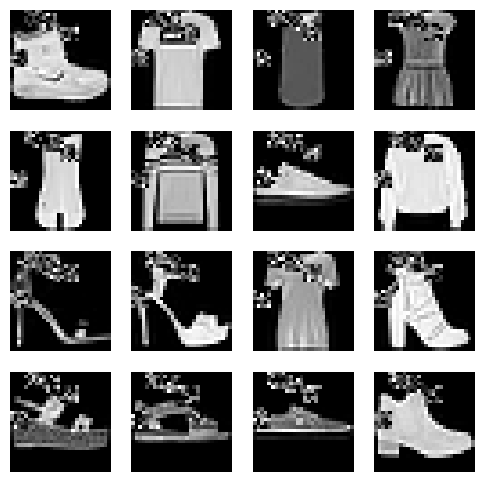

In [36]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [37]:
# Train a model with the augmentation
epochs=50
lr = 1e-2
model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs*len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
# Add the callbacks for the scheduler and the augmentation transforms
xtra = [BatchSchedCB(sched), augcb]
learn = TrainLearner(model, dls, loss_func=F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.668,1.193,0,True
0.748,0.849,0,False
0.797,0.784,1,True
0.822,0.651,1,False
0.842,0.642,2,True
0.829,0.558,2,False
0.866,0.543,3,True
0.860,0.494,3,False
0.871,0.489,4,True
0.849,0.490,4,False


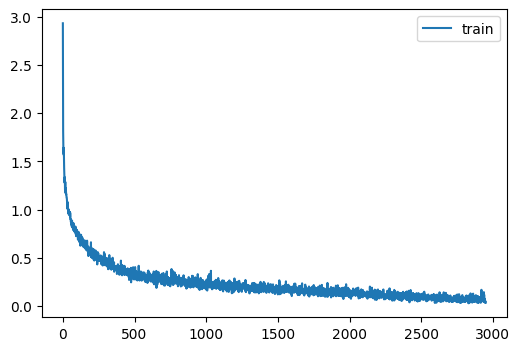

In [57]:
learn.fit(epochs)

## Random Copy

Random copy builds upon Random Erase by copytin parts of the image from one location to another.  Whether this is better that the random erase I am not sure, it is likely to maintain the dynamic range better but could confuse the classifier (at least that is my thought)

In [38]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [39]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
sty1 = int(random.random()*(1-pct)*xbt.shape[-1])
stx2 = int(random.random()*(1-pct)*xbt.shape[-2])
sty2 = int(random.random()*(1-pct)*xbt.shape[-1])
stx1,sty1,stx2,sty2,szx,szy

(12, 4, 13, 18, 5, 5)

In [40]:
xbt[:,:,stx1:stx1+szx,sty1:sty1+szy] = xbt[:,:,stx2:stx2+szx,sty2:sty2+szy]

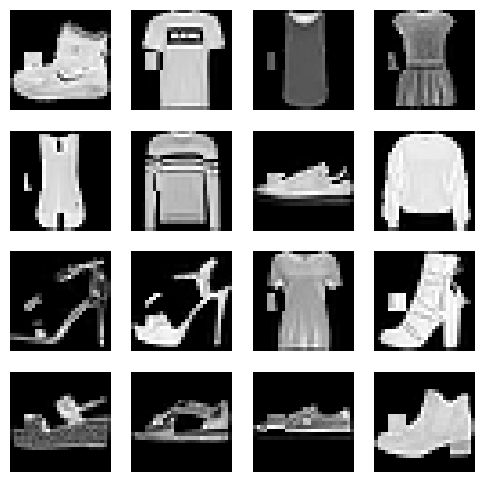

In [41]:
show_images(xbt, imsize=1.5)

In [42]:
#|export
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

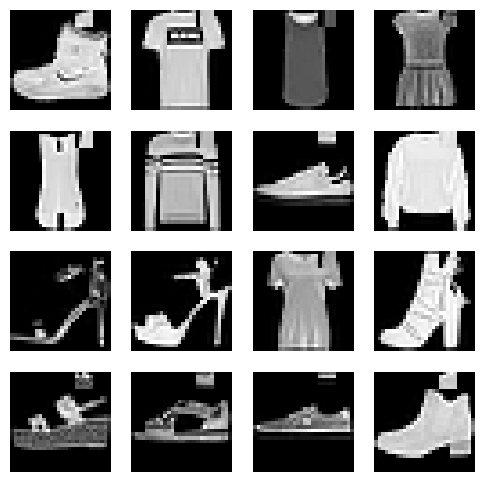

In [43]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_copy1(xbt, 0.2)
show_images(xbt, imsize=1.5)

In [44]:
#|export
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
    return x

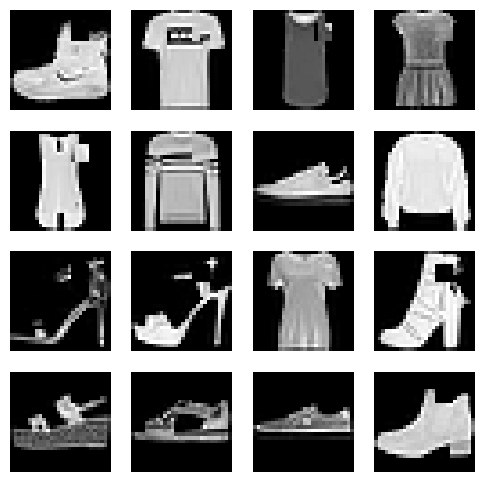

In [45]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_copy(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [46]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

In [47]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

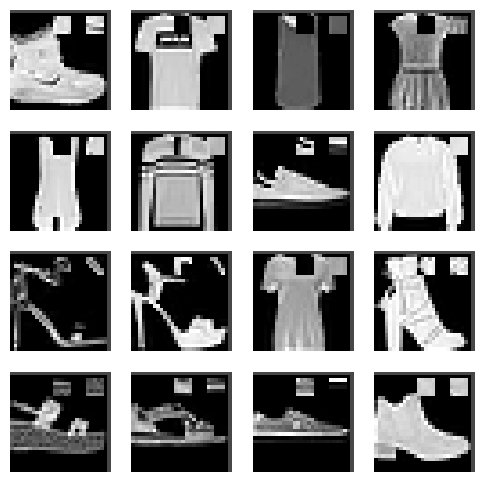

In [68]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

accuracy,loss,epoch,train
0.693,1.089,0,True
0.791,0.727,0,False
0.823,0.711,1,True
0.839,0.549,1,False
0.855,0.568,2,True
0.838,0.564,2,False
0.864,0.483,3,True
0.870,0.432,3,False
0.880,0.402,4,True
0.776,0.644,4,False


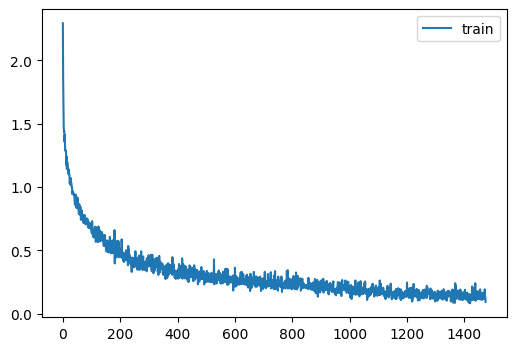

In [69]:
set_seed(1)
epochs = 25
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train
0.686,1.126,0,True
0.769,0.784,0,False
0.814,0.731,1,True
0.839,0.547,1,False
0.849,0.587,2,True
0.811,0.567,2,False
0.864,0.486,3,True
0.835,0.520,3,False
0.875,0.411,4,True
0.865,0.427,4,False


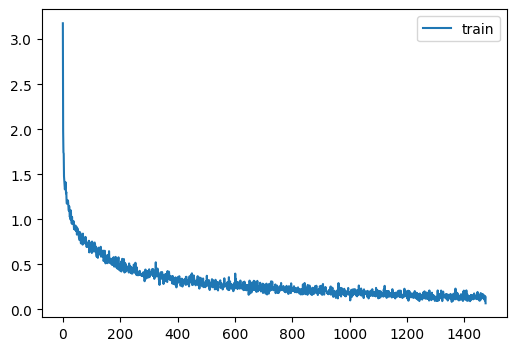

In [70]:
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

In [71]:
mdl_path = Path('models')
torch.save(learn.model,  mdl_path/'randcopy1.pkl')
torch.save(learn2.model, mdl_path/'randcopy2.pkl')

In [72]:
cp1 = CapturePreds()
learn.fit(1, train=False, cbs=cp1)

accuracy,loss,epoch,train
0.942,0.171,0,False


In [73]:
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)

accuracy,loss,epoch,train
0.943,0.169,0,False


In [74]:
ap = torch.stack([cp1.all_preds,cp2.all_preds]).mean(0).argmax(1)

In [75]:
round((ap==cp1.all_targs).float().mean().item(), 3)

0.944

## Dropout

In [48]:
p = 0.1
dist = distributions.binomial.Binomial(tensor(1.), probs=1-p)
dist.sample((10,))

tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [49]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.).to(x.device),probs=1-p)
        return x*dist.sample(x.size())*1/(1-self.p)

Create a new model with dropout in the first layer and after the flattened layer. Note that the last dropout layer uses the above wheras the earlier one uses the Pytorch version (the one above only works with 1d layers)

In [54]:
def get_dropmodel(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.0):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [58]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.740,0.937,0,train
0.863,0.464,0,eval
0.889,0.410,1,train
0.891,0.343,1,eval
0.914,0.284,2,train
0.918,0.265,2,eval
0.936,0.213,3,train
0.927,0.233,3,eval
0.953,0.164,4,train
0.932,0.214,4,eval


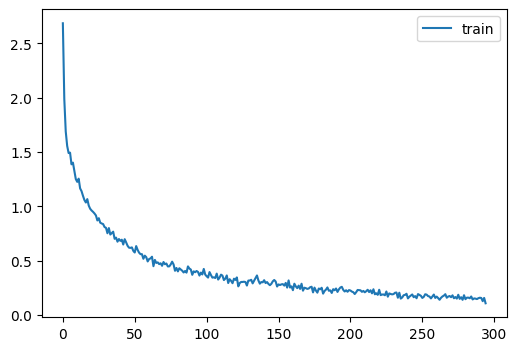

In [59]:
learn.fit(epochs)

In [60]:
class TTD_CB(Callback):
    def before_epoch(self, learn):
        learn.model.apply(lambda m: m.train() if isinstance(m, (nn.Dropout,nn.Dropout2d)) else None)

In [67]:
xb = next(iter(dls.train))[0]

In [68]:
xb.mean(), xb.std()

(tensor(0.01), tensor(1.01))

## Augment 2 

This model has been trained to work with typical diffusion models, which are usually designed to work with inputs in the range -1 to 1 (mean 0, sd=2) Of course this is unlikely to reflect the situation with any specific dataset which can have its own biases. 

In [69]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)*2-1) for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [70]:
xb = next(iter(dls.train))[0]

In [71]:
xb.mean(), xb.std()

(tensor(-0.43), tensor(0.71))

accuracy,loss,epoch,train
0.706,1.068,0,train
0.794,0.730,0,eval
0.825,0.697,1,train
0.851,0.559,1,eval
0.853,0.551,2,train
0.824,0.556,2,eval
0.854,0.491,3,train
0.848,0.461,3,eval
0.872,0.400,4,train
0.841,0.452,4,eval


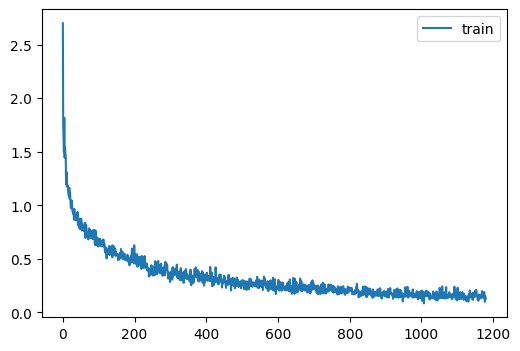

In [83]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [80]:
augcb.tfm

functools.partial(<function tfm_batch at 0x7fcf048b05e0>, tfm_x=Sequential(
  (0): RandomCrop(size=(28, 28), padding=1)
  (1): RandomHorizontalFlip(p=0.5)
  (2): RandCopy()
))

In [84]:
model

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): GeneralRelu()
  )
  (1): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): 

In [78]:
torch.save(learn.model, '/home/models/data_aug2.pkl')

### Export -

In [1]:
import nbdev; nbdev.nbdev_export()